In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    
def plot_graphs(history, generator_test):
    plt.figure(figsize=(15,7))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.5)
    plt.plot(history.history['val_accuracy'], linewidth=2.5)
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
    plt.show()

    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], 'r', linewidth=2.5)
    plt.plot(history.history['val_loss'], linewidth=2.5)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
    plt.show()


    # Generate predictions
    predictions = model.predict_generator(generator_test)

    # Get true labels
    true_labels = generator_test.classes

    # Binarize the true labels
    encoder = OneHotEncoder(sparse=False)
    true_labels = encoder.fit_transform(true_labels.reshape(-1, 1))

    # Calculate ROC curve and ROC AUC for each class
    n_classes = true_labels.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_idx in range(n_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels[:, class_idx], predictions[:, class_idx])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))
    for class_idx in range(n_classes):

        plt.plot(fpr[class_idx], tpr[class_idx], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[class_idx], class_idx),
                linewidth=2.5)

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic per Class')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
train_dir = r"/kaggle/input/ocular-toxoplasmosis/BinaryClassification/train"
test_dir = r"/kaggle/input/ocular-toxoplasmosis/BinaryClassification/val"
image_size = 128
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle=False)
num_classes = generator_train.num_classes
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 366 images belonging to 2 classes.
Found 83 images belonging to 2 classes.
{0: 1.3863636363636365, 1: 0.782051282051282}


In [4]:
from keras_cv_attention_models import maxvit
mm = maxvit.MaxViT_Tiny(input_shape=(image_size, image_size, 3), pretrained="imagenet")

>>>> Load pretrained from: /root/.keras/models/maxvit_tiny_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (128, 128)
>>>> Reload layer: stack_1_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_3/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_3/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_b

In [36]:
# mm.summary()

In [9]:
from keras_cv_attention_models import davit
mm2 = davit.DaViT_T(input_shape=(image_size, image_size, 3))

>>>> Load pretrained from: /root/.keras/models/davit_t_imagenet.h5


In [23]:
# from keras_cv_attention_models import swin_transformer_v2
# mm2 = swin_transformer_v2.SwinTransformerV2Tiny_ns(input_shape=(image_size, image_size, 3), pretrained="imagenet")

In [7]:
mm_last_layer = mm.get_layer('avg_pool').output
# out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
# mm_last_layer = GlobalAveragePooling2D()(mm_last_layer)
mm_custom = Model(mm.input, mm_last_layer)

In [12]:
mm2_last_layer = mm2.get_layer('avg_pool').output
# out2 = Dense(256, activation='relu', name='dense_1')(mm2_last_layer)
mm2_last_layer = Dense(512, activation='softmax', name='prediction1')(mm2_last_layer)
mm2_custom = Model(mm2.input, mm2_last_layer)

In [13]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(image_size, image_size, 3))
outputs = layers.average([mm_custom(inputs), mm2_custom(inputs)])
avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 512)          30167304    ['input_5[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 512)          27984896    ['input_5[0][0]']                
                                                                                                  
 average_1 (Average)            (None, 512)          0           ['model[1][0]',            

In [15]:
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average_1').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 512)          30167304    ['input_5[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 512)          27984896    ['input_5[0][0]']                
                                                                                                  
 average_1 (Average)            (None, 512)          0           ['model[1][0]',            

In [16]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight = 'DaVIT_MaxVIT.h5'
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath=weight, save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [18]:
epochs = 50

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_1530/3901355234.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/50
46/45 [==============================] - ETA: 0s - loss: 2.0522 - accuracy: 0.6503 - categorical_accuracy: 0.6503 - auc: 0.6996 - precision: 0.6503 - recall: 0.6503 - true_positives: 238.0000 - true_negatives: 238.0000 - false_positives: 128.0000 - false_negatives: 128.0000 - cohen_kappa: -0.9294 - f1_score: 0.6370
Epoch 1: val_accuracy improved from -inf to 0.73494, saving model to DaVIT_MaxVIT.h5
45/45 [==============================] - 209s 771ms/step - loss: 2.0522 - accuracy: 0.6503 - categorical_accuracy: 0.6503 - auc: 0.6996 - precision: 0.6503 - recall: 0.6503 - true_positives: 238.0000 - true_negatives: 238.0000 - false_positives: 128.0000 - false_negatives: 128.0000 - cohen_kappa: -0.9294 - f1_score: 0.6370 - val_loss: 1.0647 - val_accuracy: 0.7349 - val_categorical_accuracy: 0.7349 - val_auc: 0.7619 - val_precision: 0.7349 - val_recall: 0.7349 - val_true_positives: 61.0000 - val_true_negatives: 61.0000 - val_false_positives: 22.0000 - val_false_negatives: 22.0000 

11/11 [==============================] - 12s 205ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       1.00      0.95      0.97        56

    accuracy                           0.96        83
   macro avg       0.95      0.97      0.96        83
weighted avg       0.97      0.96      0.96        83



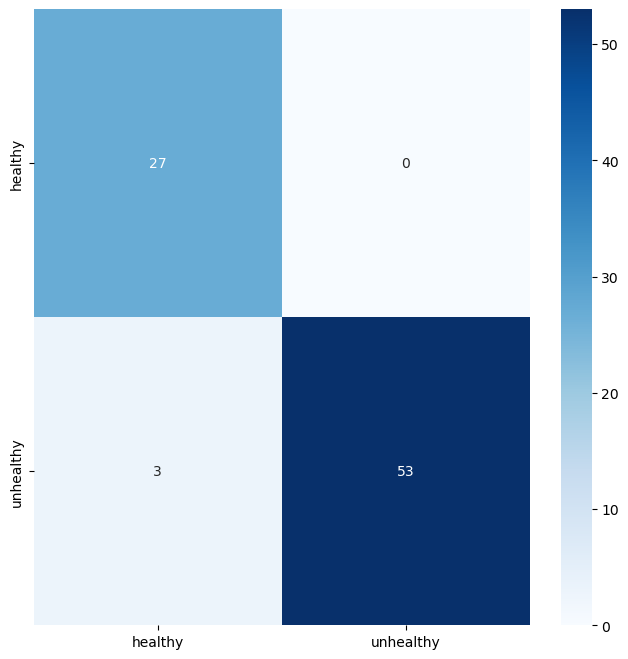

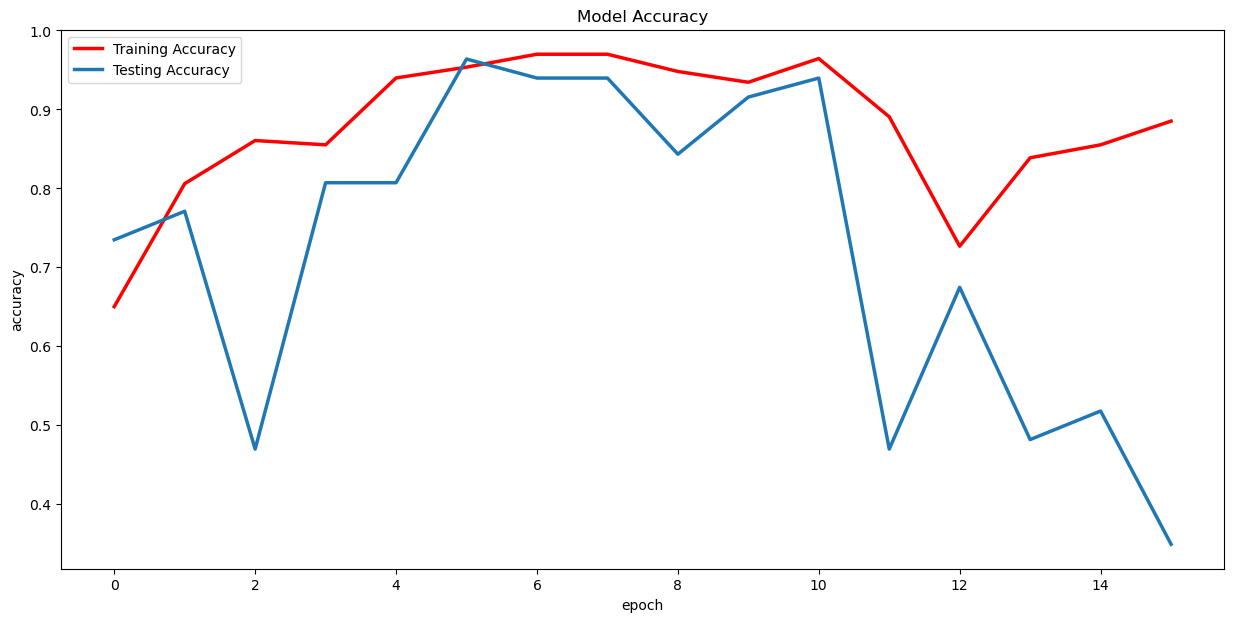

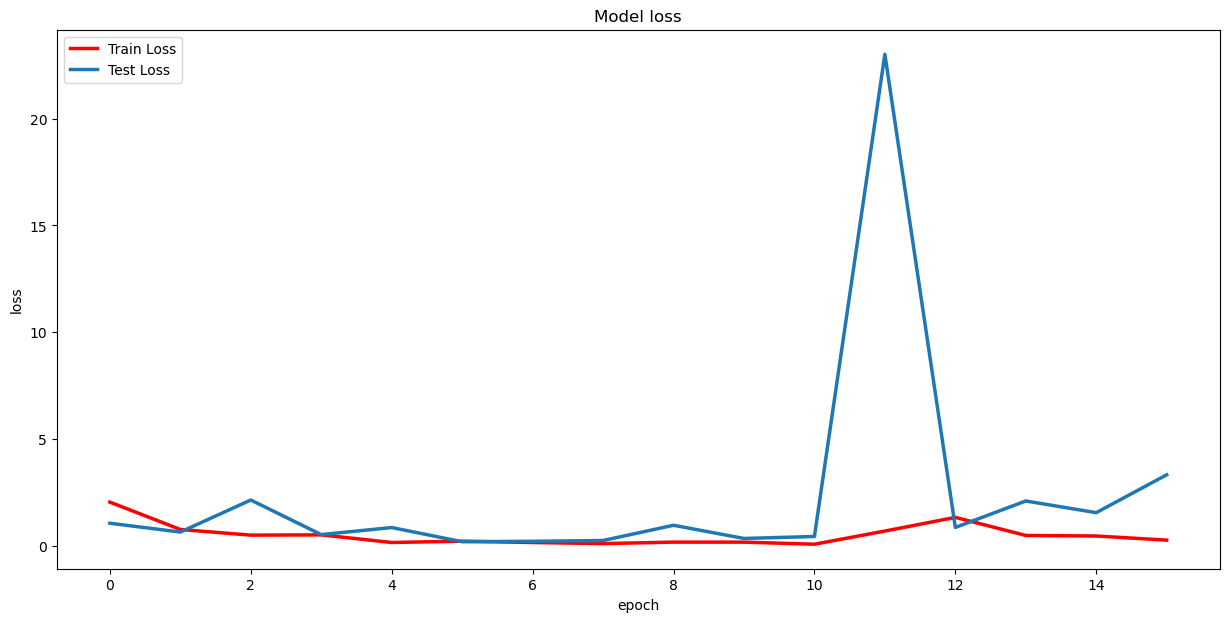

/tmp/ipykernel_1530/3330063544.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator_test)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


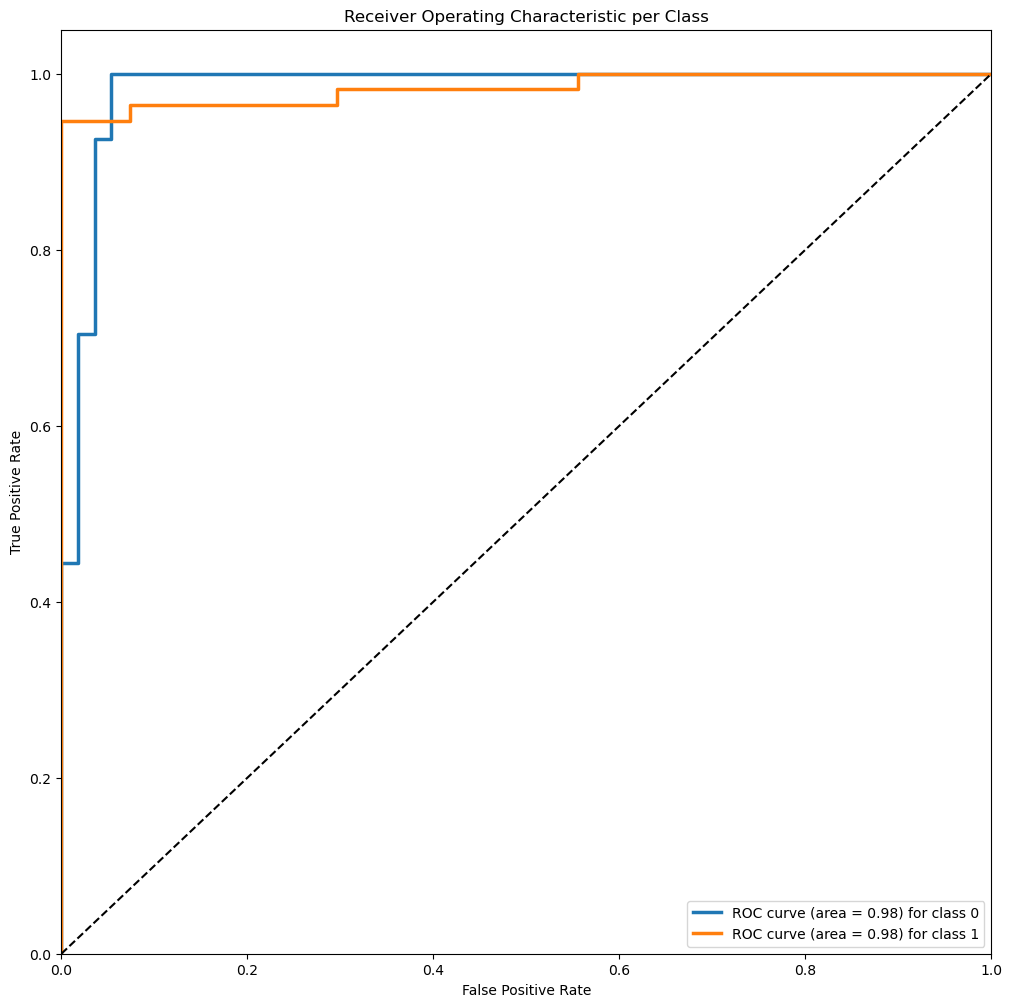

In [23]:
model = keras.models.load_model(weight)
evaluate_(model, generator_test)
plot_graphs(history, generator_test)